In [12]:
import torch

model = torch.hub.load('facebookresearch/detr:main', 'detr_resnet101', pretrained=True)
# model = model.cuda()
torch.hub.list('facebookresearch/detr:main')

Using cache found in C:\Users\A/.cache\torch\hub\facebookresearch_detr_main


In [14]:
import cv2
from torchvision.transforms import transforms as T
from PIL import Image, ImageDraw, ImageFont
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

image = Image.open('../test/6.jpg')
# image = Image.open('../coco/val2017/000000014007.jpg')

inp = transform(image).unsqueeze(0)
# inp = inp.cuda()
oup = model(inp)

In [15]:
import torchvision
from torch import tensor

def cbox2box(cbox):
    x1 = (cbox[:,0] - cbox[:,2]/2)
    y1 = (cbox[:,1] - cbox[:,3]/2)
    x2 = (cbox[:,0] + cbox[:,2]/2)
    y2 = (cbox[:,1] + cbox[:,3]/2)
    box = torch.ones_like(cbox)
    box[:,0] = x1
    box[:,1] = y1
    box[:,2] = x2
    box[:,3] = y2
    return box 

oup_lgs = oup["pred_logits"].softmax(-1)
labels = oup_lgs[..., :-1].argmax(-1)[0]
scores = oup_lgs[..., :-1].max(-1)[0][0]
scores_not1 = 1 - oup_lgs[..., -1][0] # 非背景的分数

center_boxes = oup['pred_boxes'][0] # cbox (中心x, 中心y, box宽，box高)
boxes = cbox2box(center_boxes)

# keep_i = range(labels.shape[0])

keep_i = torchvision.ops.nms(boxes, scores, iou_threshold=0.5)
keep_i = keep_i.tolist()

# # 分类型 nms
# keep_i = set()
# for label in range(90):
#     ss = oup_lgs[...,label][0]
#     ks = torchvision.ops.nms(boxes, ss, iou_threshold=0.5)
#     keep_i.update(ks.tolist())

res = []
for i in keep_i:
    label = int(labels[i])
    score = float(scores[i])
    box = boxes[i].tolist()
    # if score>0.5:
    #     res.append((label, score, box, i))
    if score>0.5 and label==5:
        res.append((label, score, box, i))

In [16]:
set(labels.tolist())

{1, 5, 9}

In [17]:
from numpy import random

W, H = image.size
draw = ImageDraw.Draw(image)
font = ImageFont.truetype("consola.ttf", 10, encoding="unic")#设置字

for it in res:
    label = it[0]
    score = it[1]
    box = it[2]
    i = it[3]
    # x1 = (box[0] - box[2]/2) * W
    # y1 = (box[1] - box[3]/2) * H
    # x2 = (box[0] + box[2]/2) * W
    # y2 = (box[1] + box[3]/2) * H
    # box = [x1,y1,x2,y2]
    box[0] *= W 
    box[1] *= H 
    box[2] *= W 
    box[3] *= H

    color = tuple(random.randint(255,size=(3)))

    draw.rectangle(box, None, color)
    # draw.text((box[0], box[1]), "(%d, %.3f, %d)"%(label, score, i), color, font)
    draw.text((box[0], box[1]), "%d"%(i), color, font)

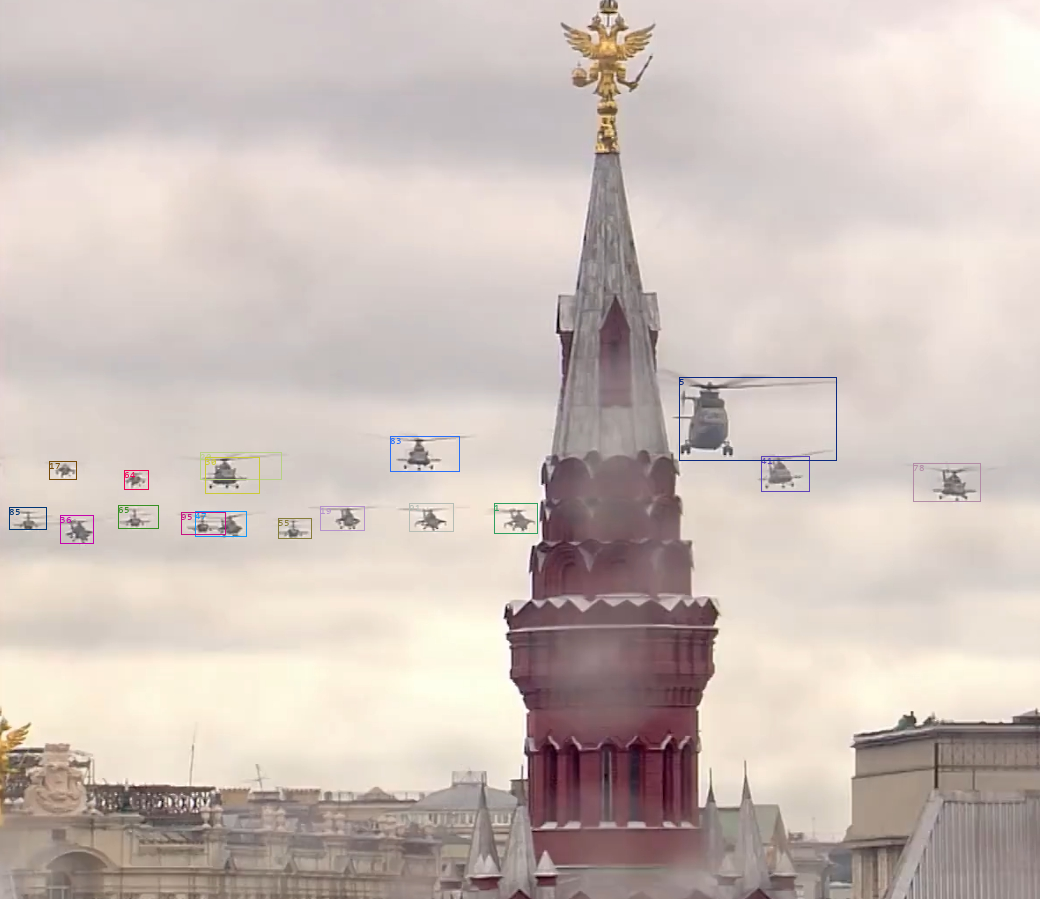

In [18]:
image